In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Get the MNIST train.csv file

https://www.kaggle.com/competitions/digit-recognizer/data

In [5]:
df = pd.read_csv("../Non_SGD/train.csv")
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data = np.array(df)
m , n = data.shape
print(m,n)

42000 785


In [7]:
np.random.shuffle(data)
data_dev = data[0:1000].T

Y_dev = data_dev[0]
X_dev = data_dev[1:n]/255.0

data_train = data[1000:m].T

Y_train = data_train[0]
X_train = data_train[1:n]/255.0

In [8]:
"""
The code x_train[:, 0].shape is checking the shape of the first image (training example) in your x_train dataset.
It selects all the pixel features for that first image and then tells you its dimensions, which is (784,),
meaning it's a 1-dimensional array of 784 pixel values.
"""
X_train[:, 0].shape

(784,)

In [9]:
print(f"Shape of x_train: {X_train.shape}")
print(f"Shape of y_train: {Y_train.shape}")

Shape of x_train: (784, 41000)
Shape of y_train: (41000,)


# Mini Batch SGD

In [7]:
import numpy as np

class Dense_Layer:
    def __init__(self, n_inputs, n_neurons):
        #self.weights = np.random.rand(n_inputs, n_neurons)
        self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2.0 / n_inputs) # HE intialization
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs

    def back(self, dZ):
        m = self.inputs.shape[0]

        self.dW = (1 / m) * np.dot(self.inputs.T, dZ)
        self.db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)

        dA_prev = np.dot(dZ, self.weights.T)
        return dA_prev


class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def back(self, dA):
        dZ = dA * (self.inputs > 0)
        return dZ


class Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def back(self, y_true):
        return self.output - y_true

class Loss:
  """Base class for loss functions."""
  def calculate(self,output,y):
    sample_losses = self.forward(output, y)
    data_loss = np.mean(sample_losses)
    return data_loss

class Loss_CategoreicalCrossEntropy(Loss):
  """Implements the Categorical Cross-Entropy loss function."""
  def forward(self, y_pred, y_true):
    samples = len(y_pred)
    y_pred_clipped = np.clip(y_pred,1e-7, 1-1e-7) #1e-7, 1-1e-7 so that log(0) is not encountered

    if len(y_true.shape) == 1:
      correct_confidences = y_pred_clipped[range(samples), y_true]

    elif len(y_true.shape) == 2:
      correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)

    negative_log_likelihoods = -np.log(correct_confidences)
    return negative_log_likelihoods

class OHE:
    def __init__(self, num_classes=10):
        self.num_classes = num_classes

    def encoding(self, inputs):
        ohe_y = np.zeros((inputs.size, self.num_classes))
        ohe_y[np.arange(inputs.size), inputs] = 1
        return ohe_y


class NeuralNetwork:
    def __init__(self):
        self.dense1 = Dense_Layer(784, 10)
        self.dense2 = Dense_Layer(10, 10)

        self.activation1 = ReLU()
        self.activation2 = Softmax()

        self.ohe = OHE()


    def forward(self, X):
        self.dense1.forward(X)

        self.activation1.forward(self.dense1.output)

        self.dense2.forward(self.activation1.output)

        self.activation2.forward(self.dense2.output)

    def backward(self, Y):
        Y_ohe = self.ohe.encoding(Y)

        dZ2 = self.activation2.back(Y_ohe)
        dA1 = self.dense2.back(dZ2)
        dZ1 = self.activation1.back(dA1)
        self.dense1.back(dZ1)

    def update(self, alpha):
        self.dense1.weights -= alpha * self.dense1.dW
        self.dense1.biases  -= alpha * self.dense1.db

        self.dense2.weights -= alpha * self.dense2.dW
        self.dense2.biases  -= alpha * self.dense2.db

    def predict(self):
        return np.argmax(self.activation2.output, axis=1)




class Trainer:
    def __init__(self, model, alpha=0.01, epochs=20, batch_size=64):
        self.model = model
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss_fn = Loss_CategoreicalCrossEntropy()
        self.loss_history = []
        self.acc_history = []

    def fit(self, X, Y):
        n_samples = X.shape[0]

        for epoch in range(self.epochs):


            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]

            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size

                X_batch = X_shuffled[start:end]
                Y_batch = Y_shuffled[start:end]


                self.model.forward(X_batch)


                loss = self.loss_fn.calculate(
                    self.model.activation2.output, Y_batch
                )


                self.model.backward(Y_batch)


                self.model.update(self.alpha)

            self.model.forward(X)
            preds = self.model.predict()
            acc = np.mean(preds == Y)
            self.loss_history.append(loss)
            self.acc_history.append(acc)

            print(
                f"Epoch {epoch+1}/{self.epochs} | "
                f"Accuracy: {acc:.4f} | "
                f"Loss: {loss:.4f}"
            )



model = NeuralNetwork()

trainer = Trainer(
    model,
    alpha=0.01,
    epochs=25,
    batch_size=64
)

trainer.fit(X_train.T, Y_train)


Epoch 1/25 | Accuracy: 0.7777 | Loss: 0.7095
Epoch 2/25 | Accuracy: 0.8598 | Loss: 0.7522
Epoch 3/25 | Accuracy: 0.8819 | Loss: 0.5022
Epoch 4/25 | Accuracy: 0.8931 | Loss: 0.4347
Epoch 5/25 | Accuracy: 0.8994 | Loss: 0.2806
Epoch 6/25 | Accuracy: 0.9033 | Loss: 0.4203
Epoch 7/25 | Accuracy: 0.9077 | Loss: 0.2545
Epoch 8/25 | Accuracy: 0.9089 | Loss: 0.2392
Epoch 9/25 | Accuracy: 0.9124 | Loss: 0.1864
Epoch 10/25 | Accuracy: 0.9139 | Loss: 0.3040
Epoch 11/25 | Accuracy: 0.9160 | Loss: 0.1972
Epoch 12/25 | Accuracy: 0.9179 | Loss: 0.1301
Epoch 13/25 | Accuracy: 0.9183 | Loss: 0.2686
Epoch 14/25 | Accuracy: 0.9195 | Loss: 0.5249
Epoch 15/25 | Accuracy: 0.9213 | Loss: 0.1197
Epoch 16/25 | Accuracy: 0.9222 | Loss: 0.3372
Epoch 17/25 | Accuracy: 0.9212 | Loss: 0.3544
Epoch 18/25 | Accuracy: 0.9216 | Loss: 0.3227
Epoch 19/25 | Accuracy: 0.9245 | Loss: 0.3423
Epoch 20/25 | Accuracy: 0.9253 | Loss: 0.5088
Epoch 21/25 | Accuracy: 0.9255 | Loss: 0.1569
Epoch 22/25 | Accuracy: 0.9257 | Loss: 0.16

# Using Adam Optimiser

In [11]:
import numpy as np

# ---------------- Dense Layer ----------------
class Dense_Layer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2.0 / n_inputs)
        self.biases = np.zeros((1, n_neurons))

        # Adam state
        self.mW = np.zeros_like(self.weights)
        self.vW = np.zeros_like(self.weights)
        self.mb = np.zeros_like(self.biases)
        self.vb = np.zeros_like(self.biases)

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def back(self, dZ):
        m = self.inputs.shape[0]
        self.dW = (1 / m) * np.dot(self.inputs.T, dZ)
        self.db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
        return np.dot(dZ, self.weights.T)

# ---------------- Activations ----------------
class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def back(self, dA):
        return dA * (self.inputs > 0)

class Softmax:
    def forward(self, inputs):
        exp_vals = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

    def back(self, y_true):
        return self.output - y_true

# ---------------- Loss ----------------
class Loss_CategoricalCrossEntropy:
    def calculate(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        return np.mean(-np.log(y_pred[range(len(y_true)), y_true]))

# ---------------- One Hot Encoder ----------------
class OHE:
    def __init__(self, num_classes=10):
        self.num_classes = num_classes

    def encoding(self, y):
        out = np.zeros((y.size, self.num_classes))
        out[np.arange(y.size), y] = 1
        return out

# ---------------- Neural Network ----------------
class NeuralNetwork:
    def __init__(self):
        self.dense1 = Dense_Layer(784, 256)
        self.dense2 = Dense_Layer(256, 128)
        self.dense3 = Dense_Layer(128, 64)
        self.dense4 = Dense_Layer(64, 10)
        self.relu1 = ReLU()
        self.relu2 = ReLU()
        self.relu3 = ReLU()
        self.softmax = Softmax()
        self.ohe = OHE()

    def forward(self, X):
        self.dense1.forward(X)
        self.relu1.forward(self.dense1.output)
        self.dense2.forward(self.relu1.output)
        self.relu2.forward(self.dense2.output)
        self.dense3.forward(self.relu2.output)
        self.relu3.forward(self.dense3.output)
        self.dense4.forward(self.relu3.output)
        self.softmax.forward(self.dense4.output)

    def backward(self, y):
        y_ohe = self.ohe.encoding(y)

        dZ4 = self.softmax.back(y_ohe)  # Softmax + CrossEntropy

        dA3 = self.dense4.back(dZ4) # Dense4 (10 → 10)

        dZ3 = self.relu3.back(dA3)  # ReLU3

        dA2 = self.dense3.back(dZ3) # Dense3 (128 → 10)

        dZ2 = self.relu2.back(dA2)  # ReLU2

        dA1 = self.dense2.back(dZ2) # Dense2 (256 → 128)

        dZ1 = self.relu1.back(dA1)  # ReLU1


        self.dense1.back(dZ1) # Dense1 (784 → 256)

    def predict(self):
        return np.argmax(self.softmax.output, axis=1)

# ---------------- Adam Optimizer ----------------
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0

    def step(self):
        self.t += 1

    def update(self, layer):


        # Weights
        layer.mW = self.beta1 * layer.mW + (1 - self.beta1) * layer.dW
        layer.vW = self.beta2 * layer.vW + (1 - self.beta2) * (layer.dW ** 2)

        mW_hat = layer.mW / (1 - self.beta1 ** self.t)
        vW_hat = layer.vW / (1 - self.beta2 ** self.t)

        layer.weights -= self.lr * mW_hat / (np.sqrt(vW_hat) + self.eps)

        # Biases
        layer.mb = self.beta1 * layer.mb + (1 - self.beta1) * layer.db
        layer.vb = self.beta2 * layer.vb + (1 - self.beta2) * (layer.db ** 2)

        mb_hat = layer.mb / (1 - self.beta1 ** self.t)
        vb_hat = layer.vb / (1 - self.beta2 ** self.t)

        layer.biases -= self.lr * mb_hat / (np.sqrt(vb_hat) + self.eps)

# ---------------- Trainer ----------------
class Trainer:
    def __init__(
        self,
        model,
        optimizer="adam",
        lr=0.001,
        beta1=0.9,
        beta2=0.999,
        epochs=20,
        batch_size=64
    ):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss_fn = Loss_CategoricalCrossEntropy()
        self.loss_history = []
        self.acc_history = []

        if optimizer == "adam":
            self.optimizer = Adam(lr, beta1, beta2)
        else:
            raise ValueError("Only Adam optimizer implemented")

    def fit(self, X, Y):
        n = X.shape[0]

        for epoch in range(self.epochs):
            perm = np.random.permutation(n)
            X, Y = X[perm], Y[perm]

            for i in range(0, n, self.batch_size):
                Xb = X[i:i+self.batch_size]
                Yb = Y[i:i+self.batch_size]

                self.model.forward(Xb)
                self.model.backward(Yb)

                self.optimizer.step()
                self.optimizer.update(self.model.dense1)
                self.optimizer.update(self.model.dense2)
                self.optimizer.update(self.model.dense3)
                self.optimizer.update(self.model.dense4)

            self.model.forward(X)
            preds = self.model.predict()
            acc = np.mean(preds == Y)
            loss = self.loss_fn.calculate(self.model.softmax.output, Y)

            self.loss_history.append(loss)
            self.acc_history.append(acc)

            print(f"Epoch {epoch+1}/{self.epochs} | Accuracy: {acc:.4f} | Loss: {loss:.4f}")

# ---------------- Run ----------------
model = NeuralNetwork()

trainer = Trainer(
    model,
    optimizer="adam",
    lr=0.0001,
    beta1=0.9,
    beta2=0.999,
    epochs=100,
    batch_size=64
)

trainer.fit(X_train.T, Y_train)

Epoch 1/100 | Accuracy: 0.9244 | Loss: 0.2681
Epoch 2/100 | Accuracy: 0.9495 | Loss: 0.1825
Epoch 3/100 | Accuracy: 0.9603 | Loss: 0.1434
Epoch 4/100 | Accuracy: 0.9647 | Loss: 0.1218
Epoch 5/100 | Accuracy: 0.9708 | Loss: 0.1038
Epoch 6/100 | Accuracy: 0.9779 | Loss: 0.0832
Epoch 7/100 | Accuracy: 0.9813 | Loss: 0.0717
Epoch 8/100 | Accuracy: 0.9848 | Loss: 0.0600
Epoch 9/100 | Accuracy: 0.9859 | Loss: 0.0539
Epoch 10/100 | Accuracy: 0.9871 | Loss: 0.0496
Epoch 11/100 | Accuracy: 0.9900 | Loss: 0.0396
Epoch 12/100 | Accuracy: 0.9911 | Loss: 0.0369
Epoch 13/100 | Accuracy: 0.9933 | Loss: 0.0306
Epoch 14/100 | Accuracy: 0.9913 | Loss: 0.0324
Epoch 15/100 | Accuracy: 0.9947 | Loss: 0.0249
Epoch 16/100 | Accuracy: 0.9952 | Loss: 0.0223
Epoch 17/100 | Accuracy: 0.9978 | Loss: 0.0158
Epoch 18/100 | Accuracy: 0.9975 | Loss: 0.0146
Epoch 19/100 | Accuracy: 0.9976 | Loss: 0.0148
Epoch 20/100 | Accuracy: 0.9981 | Loss: 0.0126
Epoch 21/100 | Accuracy: 0.9991 | Loss: 0.0091
Epoch 22/100 | Accurac

In [21]:
num_params_dense1_weights = model.dense1.weights.size
num_params_dense1_biases = model.dense1.biases.size
num_params_dense2_weights = model.dense2.weights.size
num_params_dense2_biases = model.dense2.biases.size
num_params_dense3_weights = model.dense3.weights.size
num_params_dense3_biases = model.dense3.biases.size
num_params_dense4_weights = model.dense4.weights.size
num_params_dense4_biases = model.dense4.biases.size

total_parameters = (num_params_dense1_weights + num_params_dense1_biases +
                    num_params_dense2_weights + num_params_dense2_biases +
                    num_params_dense3_weights + num_params_dense3_biases +
                    num_params_dense4_weights + num_params_dense4_biases)

print(f"Parameters in Dense Layer 1 (Weights): {num_params_dense1_weights}")
print(f"Parameters in Dense Layer 1 (Biases): {num_params_dense1_biases}")
print(f"Parameters in Dense Layer 2 (Weights): {num_params_dense2_weights}")
print(f"Parameters in Dense Layer 2 (Biases): {num_params_dense2_biases}")
print(f"Parameters in Dense Layer 3 (Weights): {num_params_dense3_weights}")
print(f"Parameters in Dense Layer 3 (Biases): {num_params_dense3_biases}")
print(f"Parameters in Dense Layer 4 (Weights): {num_params_dense4_weights}")
print(f"Parameters in Dense Layer 4 (Biases): {num_params_dense4_biases}")
print(f"Total parameters in the model: {total_parameters}")

Parameters in Dense Layer 1 (Weights): 200704
Parameters in Dense Layer 1 (Biases): 256
Parameters in Dense Layer 2 (Weights): 32768
Parameters in Dense Layer 2 (Biases): 128
Parameters in Dense Layer 3 (Weights): 1280
Parameters in Dense Layer 3 (Biases): 10
Parameters in Dense Layer 4 (Weights): 100
Parameters in Dense Layer 4 (Biases): 10
Total parameters in the model: 235256


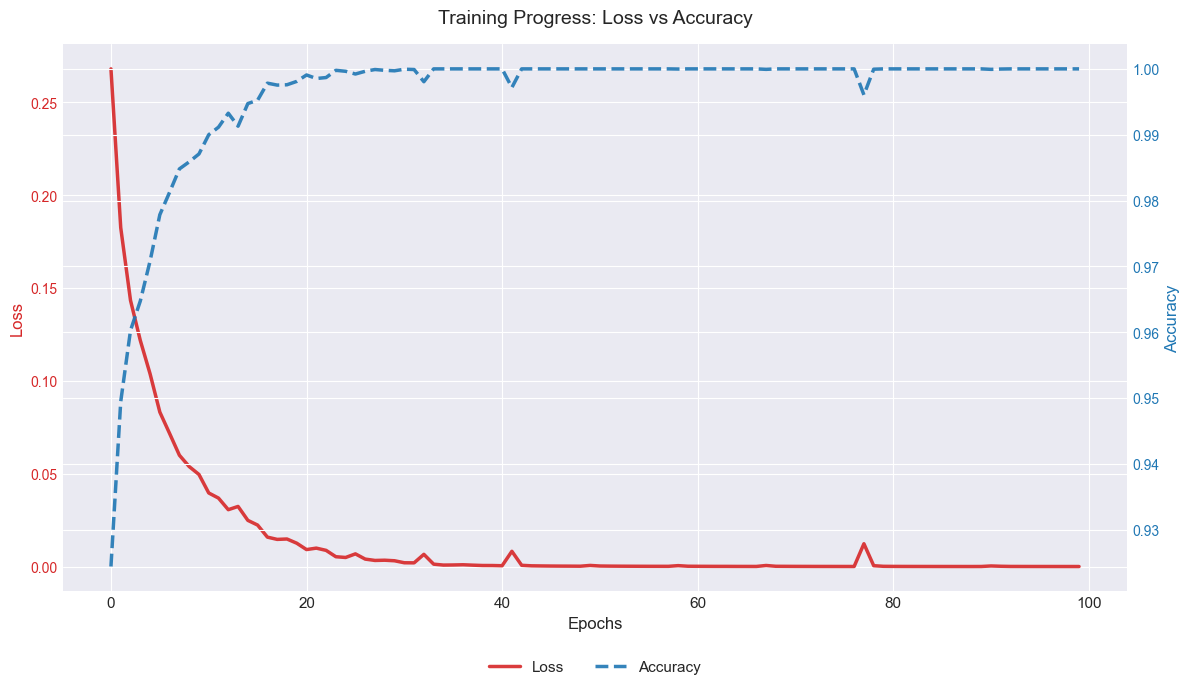

In [12]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")  # clean readable style

fig, ax1 = plt.subplots(figsize=(12, 7))

# ---- Loss (left Y-axis) ----
loss_line, = ax1.plot(
    trainer.loss_history,
    color="tab:red",
    linestyle="-",
    linewidth=2.5,
    label="Loss",
    alpha=0.9
)

ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12, color="tab:red")
ax1.tick_params(axis='y', labelcolor="tab:red")
ax1.tick_params(axis='x', labelsize=11)

# ---- Accuracy (right Y-axis) ----
ax2 = ax1.twinx()

acc_line, = ax2.plot(
    trainer.acc_history,
    color="tab:blue",
    linestyle="--",
    linewidth=2.5,
    label="Accuracy",
    alpha=0.9
)

ax2.set_ylabel("Accuracy", fontsize=12, color="tab:blue")
ax2.tick_params(axis='y', labelcolor="tab:blue")

# ---- Title ----
plt.title("Training Progress: Loss vs Accuracy", fontsize=14, pad=15)

# ---- Legend ----
ax1.legend(
    handles=[loss_line, acc_line],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
    frameon=False,
    fontsize=11
)

plt.tight_layout()
plt.show()

In [13]:
def make_predictions_oop(X, model):
    model.forward(X)
    predictions = model.predict()
    return predictions
def test_prediction_oop(index, model, X_train, Y_train):
    # single image (same slicing logic)
    current_image = X_train[:, index].reshape(1, -1)

    prediction = make_predictions_oop(current_image, model)
    label = Y_train[index]
    print("Prediction:", prediction[0])
    print("Label:", label)

    # reshape & display image
    image = current_image.reshape(28, 28) * 255
    plt.gray()
    plt.imshow(image, interpolation='nearest')
    plt.show()

Prediction: 5
Label: 5


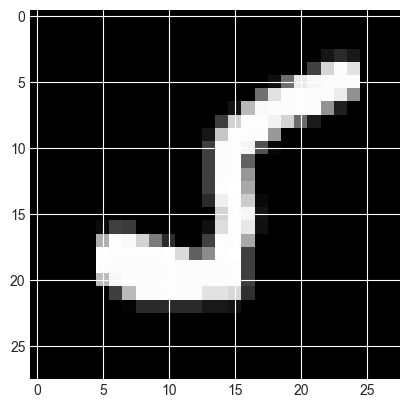

Prediction: 9
Label: 9


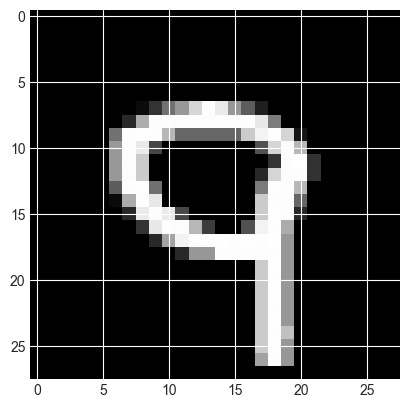

Prediction: 5
Label: 5


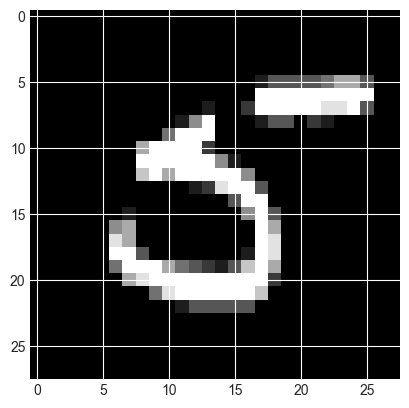

Prediction: 6
Label: 6


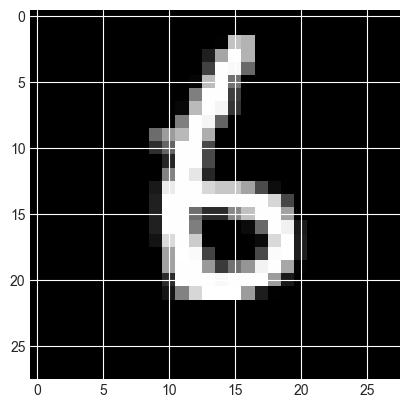

Prediction: 8
Label: 8


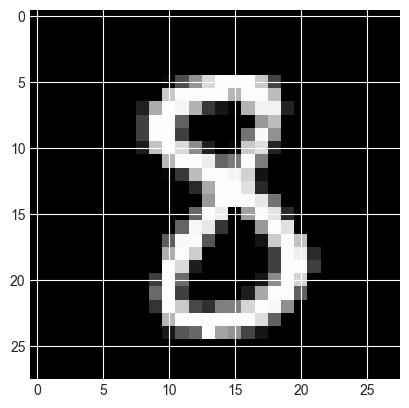

Prediction: 4
Label: 4


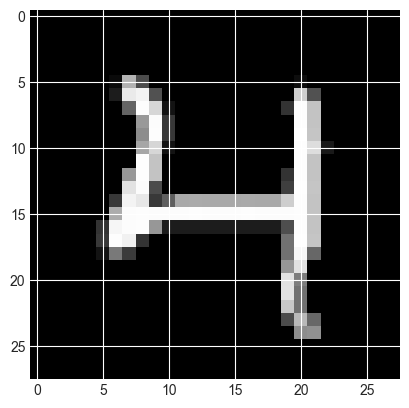

Prediction: 7
Label: 7


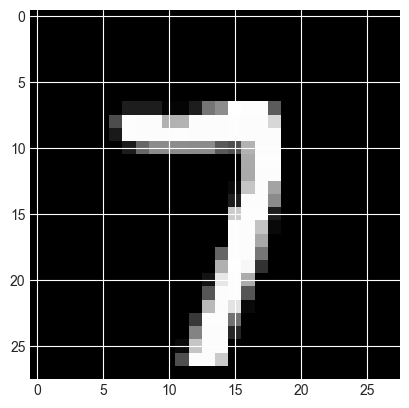

Prediction: 6
Label: 6


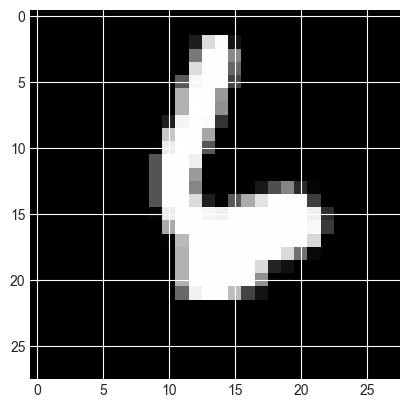

Prediction: 1
Label: 1


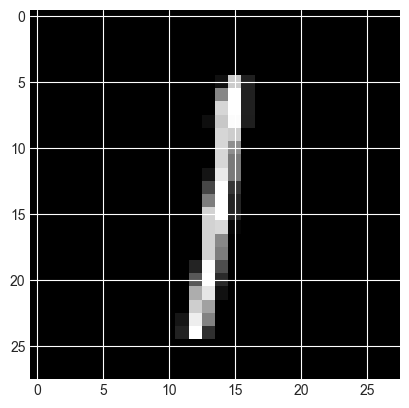

Prediction: 6
Label: 6


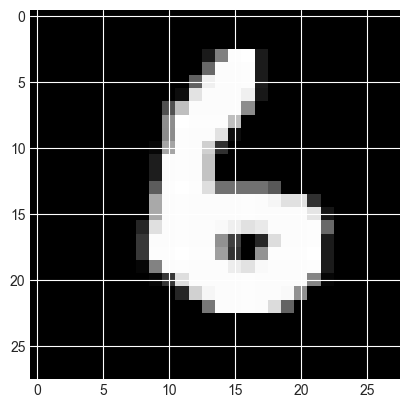

In [16]:
test_prediction_oop(0, model, X_train, Y_train)
test_prediction_oop(1, model, X_train, Y_train)
test_prediction_oop(2, model, X_train, Y_train)
test_prediction_oop(3, model, X_train, Y_train)
test_prediction_oop(4, model, X_train, Y_train)
test_prediction_oop(5, model, X_train, Y_train)
test_prediction_oop(6, model, X_train, Y_train)
test_prediction_oop(7, model, X_train, Y_train)
test_prediction_oop(8, model, X_train, Y_train)
test_prediction_oop(9, model, X_train, Y_train)

In [15]:
model.forward(X_dev.T)
dev_predictions = model.predict()
print("Dev accuracy:", np.mean(dev_predictions == Y_dev))

Dev accuracy: 0.977


Prediction: 2
Label: 2


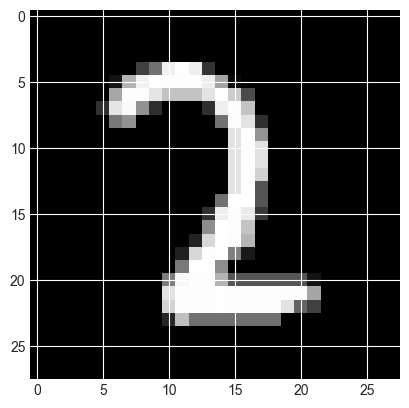

Prediction: 5
Label: 5


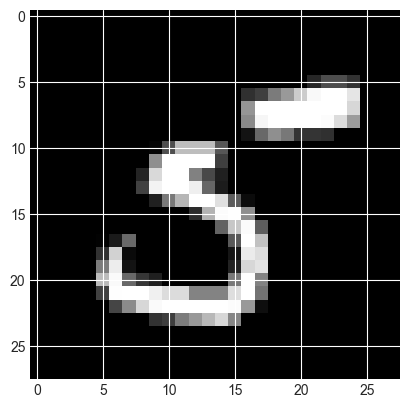

Prediction: 9
Label: 4


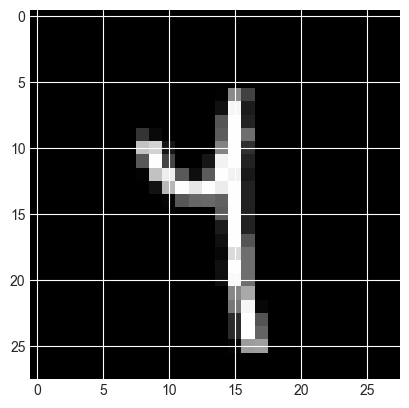

Prediction: 1
Label: 1


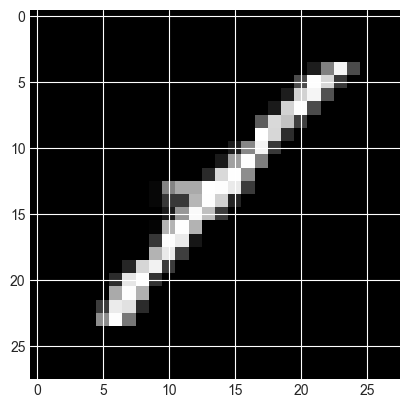

Prediction: 8
Label: 8


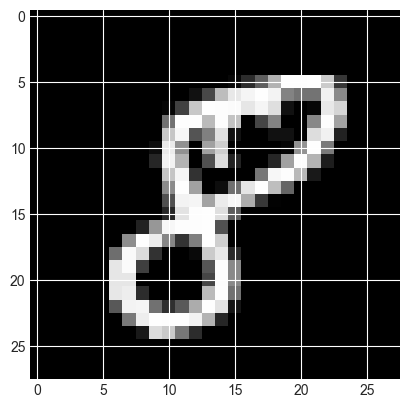

Prediction: 9
Label: 9


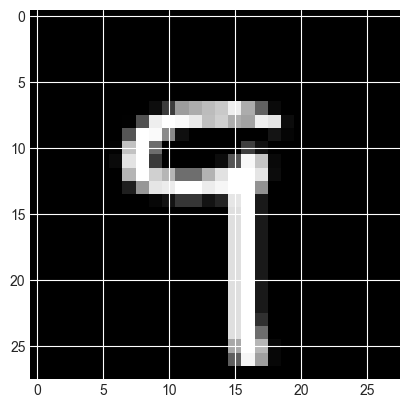

Prediction: 0
Label: 0


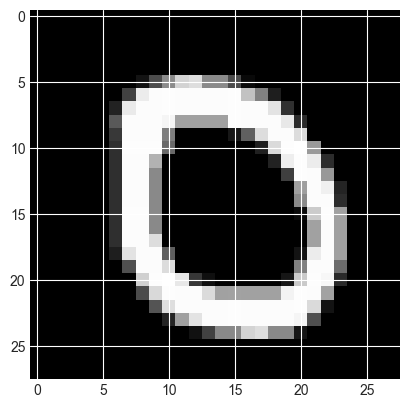

Prediction: 0
Label: 0


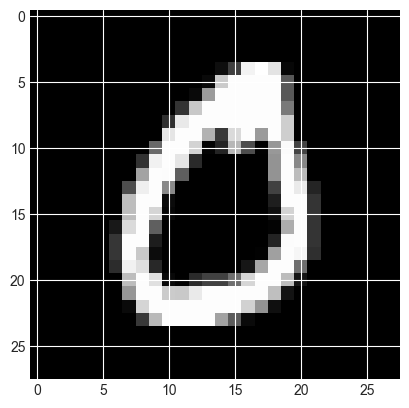

Prediction: 8
Label: 8


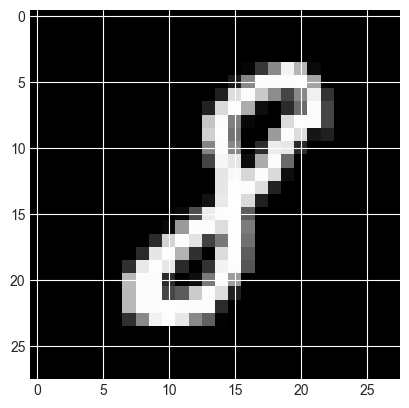

Prediction: 2
Label: 2


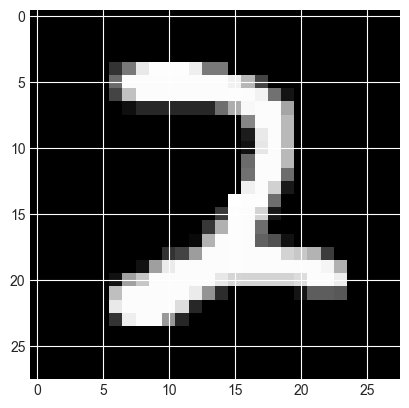

In [17]:
test_prediction_oop(0, model, X_dev, Y_dev)
test_prediction_oop(1, model, X_dev, Y_dev)
test_prediction_oop(2, model, X_dev, Y_dev)
test_prediction_oop(3, model, X_dev, Y_dev)
test_prediction_oop(4, model, X_dev, Y_dev)
test_prediction_oop(5, model, X_dev, Y_dev)
test_prediction_oop(6, model, X_dev, Y_dev)
test_prediction_oop(7, model, X_dev, Y_dev)
test_prediction_oop(8, model, X_dev, Y_dev)
test_prediction_oop(9, model, X_dev, Y_dev)

In [ ]:
df2 = pd.read_csv("/content/test.csv")
df2

In [ ]:
X_test = df2.values

# Normalize (same as training)
X_test = X_test / 255.0

In [ ]:
X_test.shape

In [ ]:
model.forward(X_test)

# Get predictions
test_predictions = model.predict()

In [ ]:
print(test_predictions[:10])
print(test_predictions.shape)   # (10000,)


In [ ]:
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(test_predictions) + 1),
    "Label": test_predictions
})


In [ ]:
submission.head()


In [ ]:
submission.to_csv("output.csv", index=False)